In [ ]:
!git clone --depth 1 https://github.com/google/automl

Cloning into 'automl'...
remote: Enumerating objects: 156, done.
remote: Counting objects: 100% (156/156), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 156 (delta 16), reused 52 (delta 0), pack-reused 0
Receiving objects: 100% (156/156), 11.99 MiB | 6.78 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [ ]:
!cd /content/automl/efficientdet; pip install -r requirements.txt

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
import os
import sys

sys.path.append('/content/automl/efficientdet')

import inference
import hparams_config
from tf2 import anchors
from tf2 import efficientdet_keras
import tensorflow as tf

import matplotlib.pyplot as plt
import cv2
from model_inspect import ModelInspector
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir VOCdevkit
!cp -r /content/drive/MyDrive/01_이미지데이터/Classification_Persimmon /content/

In [ ]:
infer_config = hparams_config.get_efficientdet_config('efficientdet-d4')

# config의 특정 항목을 update
infer_config.model_name = 'efficientdet-d4'
infer_config.model_dir = '/content/drive/MyDrive/model_trained_d4_Remove_Aug'
# infer_config의 num_classes는 2로 바뀌어야 함. 
infer_config.num_classes = 8
infer_config.is_training_bn = False
infer_config.nms_configs.score_thresh = 0.2

print(infer_config)

act_type: swish
alpha: 0.25
anchor_scale: 4.0
apply_bn_for_resampling: true
aspect_ratios:
- 1.0
- 2.0
- 0.5
autoaugment_policy: null
backbone_config: null
backbone_name: efficientnet-b4
box_class_repeats: 4
box_loss_weight: 50.0
ckpt_var_scope: null
clip_gradients_norm: 10.0
conv_after_downsample: false
conv_bn_act_pattern: false
data_format: channels_last
dataset_type: null
delta: 0.1
drop_remainder: true
first_lr_drop_epoch: 200.0
fpn_cell_repeats: 7
fpn_config: null
fpn_name: null
fpn_num_filters: 224
fpn_weight_method: null
gamma: 1.5
grad_checkpoint: false
grid_mask: false
heads:
- object_detection
image_size: 1024
img_summary_steps: null
input_rand_hflip: true
iou_loss_type: null
iou_loss_weight: 1.0
is_training_bn: false
jitter_max: 2.0
jitter_min: 0.1
label_map: null
label_smoothing: 0.0
learning_rate: 0.08
loss_scale: null
lr_decay_method: cosine
lr_warmup_epoch: 1.0
lr_warmup_init: 0.008
map_freq: 5
max_instances_per_image: 100
max_level: 7
mean_rgb:
- 123.675
- 116.28
- 103

In [ ]:
model = efficientdet_keras.EfficientDetModel(config=infer_config)
model.build((None, None, None, 3))
print('#### checkpoint name:', tf.train.latest_checkpoint(infer_config.model_dir))
model.load_weights(tf.train.latest_checkpoint(infer_config.model_dir))
model.summary()

/content/automl/efficientdet/utils.py:23: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  from tensorflow.python.tpu import tpu_function  # pylint:disable=g-direct-tensorflow-import
/content/automl/efficientdet/utils.py:255: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  for u in self.updates:


#### checkpoint name: /content/drive/MyDrive/model_trained_d4_Remove_Aug/ckpt-27
Model: ""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b4 (Model)     multiple                  16863832  
                                                                 
 resample_p6 (ResampleFeatur  multiple                 101472    
 eMap)                                                           
                                                                 
 resample_p7 (ResampleFeatur  multiple                 0         
 eMap)                                                           
                                                                 
 fpn_cells (FPNCells)        multiple                  3276133   
                                                                 
 class_net (ClassNet)        multiple                  245800    
                                                   

In [ ]:
class ExportModel(tf.Module):

  def __init__(self, model):
    super().__init__()
    self.model = model

  @tf.function
  def f(self, imgs):
    #model(imgs, training=False, post_mode='global')
    return self.model(imgs, training=False, post_mode='global')

export_model = ExportModel(model)

In [ ]:
import numpy as np

#결과값 테이블로 재정의하기 위한 함수, 현재 1개의 이미지만 인풋값으로 받음 => 5개 한꺼번에 받도록 추가
#결과값 리스트로 반환 예정
def get_detected_img(export_model, file_path, name, IsShow = True):
  
  Anthrax = 0 
  StinkBug = 0
  Wounds = 0
  BlackSpot1 = 0
  BlackSpot2 = 0
  BlackSpot3 = 0
  ScaleInsects = 0

  green_color=(0, 255, 0)
  red_color=(255, 0, 0)
  
  isFirst = True
  isFirst2 = True
  for file in os.listdir(f'{file_path}/{name}'):
    if ".jpg" in file:
      img_array = cv2.cvtColor(cv2.imread(f'{file_path}/{name}/{file}'), cv2.COLOR_BGR2RGB)
      # cv2로 만들어진 numpy image array를 tensor로 변환
      img_tensor = tf.convert_to_tensor(img_array, dtype=tf.uint8)[tf.newaxis, ...]
      boxes, scores, classes, valid_len = export_model.f(img_tensor)

      boxes = boxes.numpy()
      scores = scores.numpy()
      classes = classes.numpy()
      valid_len = valid_len.numpy()

      if IsShow:
        # 이미지 5장 하나로 합치기
        if isFirst == True:
          base = cv2.cvtColor(cv2.imread(f'{file_path}/{name}/{file}'), cv2.COLOR_BGR2RGB)
        else:
          img2 = cv2.cvtColor(cv2.imread(f'{file_path}/{name}/{file}'), cv2.COLOR_BGR2RGB)
      
      # 3: 'LiftedStem', 5:'SoftPersimmon'  ==> 클래스가 둘 중 하나에 해당하면 이미 불량이니 알고리즘 종료
      for i in classes[0]:
        if(labels_to_names[i] == 'LiftedStem' or labels_to_names[i] == 'SoftPersimmon'):
          return [0]

      # detected 된 object들을 iteration 하면서 정보 추출. detect된 object의 갯수는 100개
      for i in range(valid_len[0]):
        # detection score를 iteration시 마다 높은 순으로 추출하고 SCORE_THRESHOLD보다 낮으면 loop 중단. 
        score = scores[0, i]
        
        # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
        box = boxes[0, i]
    
        ''' **** 주의 ******
        box는 ymin, xmin, ymax, xmax 순서로 되어 있음. 또한 원본 좌표값으로 되어 있음. '''
        left = round(box[1])
        right = round(box[3])
        top = round(box[0]) 
        bottom = round(box[2])
    
        area = (bottom - top) * (right - left)
    
        # class id 추출하고 class 명으로 매핑
        class_name = labels_to_names[classes[0, i]]
        caption = f"{class_name}: {score:.4f}"
        print(caption)

        # 객체 박스 생성
        if IsShow:
          if isFirst == True:
            cv2.rectangle(base, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=1)
            cv2.putText(base, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.2, red_color, 1)
          else:
            cv2.rectangle(img2, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=1)
            cv2.putText(img2, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.2, red_color, 1)


        if(class_name == 'Anthrax'):
          Anthrax += area
        elif(class_name == 'StinkBug'):
          StinkBug += area
        elif(class_name == 'Wounds'):
          Wounds += area
        elif(class_name == 'BlackSpot1'):
          BlackSpot1 += area
        elif(class_name == 'BlackSpot2'):
          BlackSpot2 += area
        elif(class_name == 'BlackSpot3'):
          BlackSpot3 += area
        elif(class_name == 'ScaleInsects'):
          ScaleInsects += area
        
        print(f'{class_name} : {area} 제곱 면적')
      if IsShow:  
        if isFirst == False:
          base = np.hstack((base, img2))
      isFirst = False
  if IsShow:
    fig = plt.figure(figsize=(30,10))
    plt.imshow(base)

  return [Anthrax, StinkBug, Wounds, BlackSpot1, BlackSpot2, BlackSpot3, ScaleInsects]   

  

In [ ]:
labels_to_names =  { 1:'Anthrax', 2: 'LiftedStem', 3: 'StinkBug', 4: 'Wounds', 5: 'BlackSpot1', 6: 'BlackSpot2', 7: 'BlackSpot3', 8:'ScaleInsects'}  # 9: 'SoftPersimmon',

ScaleInsects: 0.4764
ScaleInsects : 361 제곱 면적
ScaleInsects: 0.4639
ScaleInsects : 380 제곱 면적
ScaleInsects: 0.4624
ScaleInsects : 552 제곱 면적
BlackSpot3: 0.3571
BlackSpot3 : 235520 제곱 면적
ScaleInsects: 0.3005
ScaleInsects : 272 제곱 면적
BlackSpot1: 0.7733
BlackSpot1 : 1740 제곱 면적
Anthrax: 0.6207
Anthrax : 260096 제곱 면적
ScaleInsects: 0.5232
ScaleInsects : 272 제곱 면적
ScaleInsects: 0.5102
ScaleInsects : 256 제곱 면적
ScaleInsects: 0.5062
ScaleInsects : 504 제곱 면적
ScaleInsects: 0.4961
ScaleInsects : 210 제곱 면적
ScaleInsects: 0.4961
ScaleInsects : 288 제곱 면적
ScaleInsects: 0.4849
ScaleInsects : 196 제곱 면적
ScaleInsects: 0.4845
ScaleInsects : 306 제곱 면적
ScaleInsects: 0.4820
ScaleInsects : 225 제곱 면적
ScaleInsects: 0.4792
ScaleInsects : 224 제곱 면적
ScaleInsects: 0.4670
ScaleInsects : 289 제곱 면적
ScaleInsects: 0.4606
ScaleInsects : 225 제곱 면적
ScaleInsects: 0.4544
ScaleInsects : 272 제곱 면적
ScaleInsects: 0.4316
ScaleInsects : 304 제곱 면적
ScaleInsects: 0.4268
ScaleInsects : 408 제곱 면적
ScaleInsects: 0.4178
ScaleInsects : 408 제곱 면적

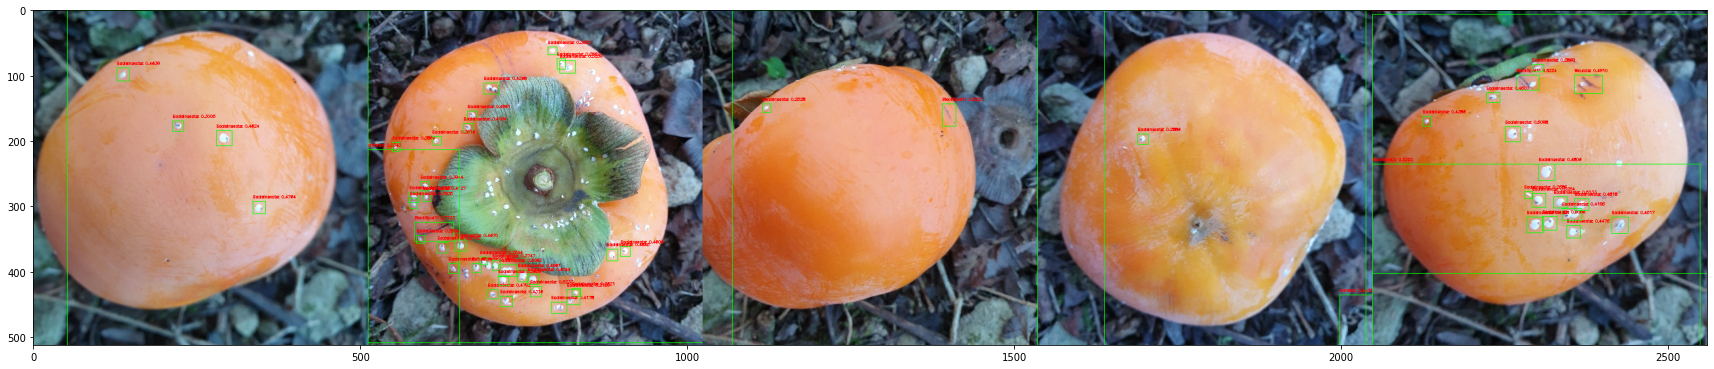

In [ ]:
base = get_detected_img(export_model,'/content/Classification_Persimmon', 'persimmon.1')

In [ ]:
base

[15697, 1214606, 0, 1204, 3259, 0, 374297]

In [ ]:
!pip install pycaret

In [ ]:
persimmonDF = pd.read_excel('/content/drive/MyDrive/persimmonDF_0118.xlsx')
persimmonDF.set_index('name', inplace=True)

persimmonDF.drop(persimmonDF[persimmonDF['Grade'] == '보류'].index, inplace = True)
persimmonDF.drop(persimmonDF[persimmonDF['Grade'] == '다시'].index, inplace = True)

npersimmonDF = persimmonDF.drop(['Grade'], axis=1)

In [ ]:
ada_saved = load_model('ada_saved')
resault = ada_saved.predict(npersimmonDF)
print(resault)